In [5]:
from pathlib import Path
import pickle

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import shap
import xgboost as xgb
from sklearn.metrics import auc, roc_curve

from hp_pred.experiments import bootstrap_test

optuna.logging.set_verbosity(optuna.logging.WARNING)

In [6]:
SIGNAL_FEATURE = ['mbp', 'sbp', 'dbp', 'hr', 'rr', 'spo2', 'etco2', 'mac', 'pp_ct', 'rf_ct', 'body_temp']
STATIC_FEATURE = ["age", "bmi", "asa"]
HALF_TIME_FILTERING = [60, 3*60, 60*10]

FEATURE_NAME = (
    [
        f"{signal}_constant_{half_time}"
        for signal in SIGNAL_FEATURE
        for half_time in HALF_TIME_FILTERING
    ]
    + [
        f"{signal}_slope_{half_time}"
        for signal in SIGNAL_FEATURE
        for half_time in HALF_TIME_FILTERING
    ]
    + [
        f"{signal}_std_{half_time}"
        for signal in SIGNAL_FEATURE
        for half_time in HALF_TIME_FILTERING
    ]
    + STATIC_FEATURE
)

#remove feature with std_60 in the name
FEATURE_NAME = [x for x in FEATURE_NAME if "std_60" not in x]

BASELINE_FEATURE_NAME = 'last_map_value'

## Load and format data

In [7]:
# import the data frame and add the meta data to the segments
dataset_name = '30_s_remi_dataset'
model_filename = Path('xgb_30_s_remi.json')

data = pd.read_parquet(Path(f'data/datasets/{dataset_name}/cases/'))

static = pd.read_parquet(f'data/datasets/{dataset_name}/meta.parquet')

data = data.merge(static, on='caseid')

## Train or load existing model


In [8]:
# control reproducibility
rng_seed = 42

result_folder = Path("data/results")
if not result_folder.exists():
    result_folder.mkdir()


# create a regressor
model_path = Path('data/models') / model_filename
if model_path.exists():
    model = xgb.XGBClassifier()
    model.load_model(model_path)
else:
    ImportError("Model file does not exist, run the xgboost study first")

leading_time_list = [3,4,5,6]
for leading_time in leading_time_list:
    data_lead = data[(data.time_before_IOH >= leading_time*60) | (data.time_before_IOH.isna())]

    test = data_lead[data_lead['split'] == "test"].copy()

    test.label_id = test.label_id.astype(str) + test.caseid.astype(str)

    test = test.dropna(subset=FEATURE_NAME)
    print('leading time:', leading_time)
    print(
        f'{len(test)} test samples, positive rate = {test["label"].mean():.2%}'
    )


    # test the model
    y_pred = model.predict_proba(test[FEATURE_NAME])[:, 1]
    y_test = test["label"].values
    y_label_id = test["label_id"].values

    dict_results, _, _ = bootstrap_test(y_test, y_pred, y_label_id, n_bootstraps=200, rng_seed=rng_seed)

    roc_results = result_folder / f"xgboost_lead_{leading_time}.pkl"
    with roc_results.open("wb") as f:
        pickle.dump(dict_results, f)

    # test baseline
    y_pred_baseline = 1 - test[BASELINE_FEATURE_NAME].values/120

    dict_results, _, _ = bootstrap_test(y_test, y_pred_baseline, y_label_id, n_bootstraps=200, rng_seed=rng_seed)

    roc_results = result_folder / f"baseline_lead_{leading_time}.pkl"
    with roc_results.open("wb") as f:
        pickle.dump(dict_results, f)


leading time: 3
172183 test samples, positive rate = 6.40%


100%|██████████| 200/200 [04:42<00:00,  1.41s/it]


leading time: 4
170497 test samples, positive rate = 5.48%


100%|██████████| 200/200 [03:44<00:00,  1.12s/it]


leading time: 5
168884 test samples, positive rate = 4.57%


100%|██████████| 200/200 [02:25<00:00,  1.38it/s]


leading time: 6
167362 test samples, positive rate = 3.71%


100%|██████████| 200/200 [01:57<00:00,  1.70it/s]


## Plot

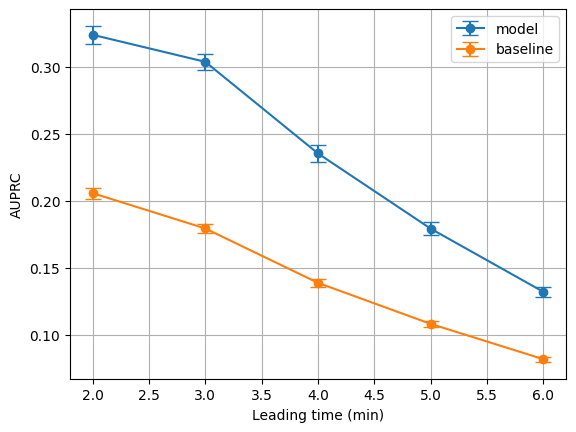

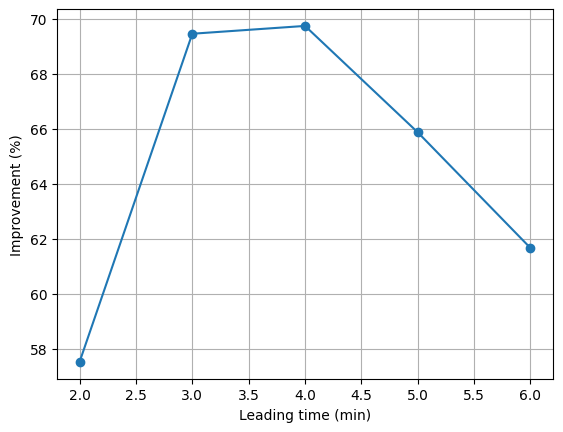

In [9]:
result_folder = Path("data/results")
xgboost_auc_list, baseline_auc_list, lead_time_list = [], [], []
xgboost_auc_std_list, baseline_auc_std_list = [], []
improvment = []
leading_time_list = [2,3,4,5,6]
for leading_time in leading_time_list:
    lead_time_list.append(leading_time)
    if leading_time == 2:
        roc_results = result_folder / "xgboost_roc_30_s.pkl"
    else:
        roc_results = result_folder / f"xgboost_lead_{leading_time}.pkl"
    with roc_results.open("rb") as f:
        dict_xgb = pickle.load(f)
    
    xgboost_auc_list.append(np.mean(dict_xgb['auprcs']))
    xgboost_auc_std_list.append(np.std(dict_xgb['auprcs']))

    if leading_time == 2:
        roc_results = result_folder / "baseline_results.csv"
    else:
        roc_results = result_folder / f"baseline_lead_{leading_time}.csv"
    with roc_results.open("rb") as f:
        dict_baseline = pickle.load(f)

    baseline_auc_list.append(np.mean(dict_baseline['auprcs']))
    baseline_auc_std_list.append(np.std(dict_baseline['auprcs']))

    improvment.append((xgboost_auc_list[-1] - baseline_auc_list[-1]) / baseline_auc_list[-1] * 100)
    

plt.errorbar(lead_time_list, xgboost_auc_list,xgboost_auc_std_list, fmt='-o', label='model', capsize=6)
plt.errorbar(lead_time_list, baseline_auc_list, baseline_auc_std_list, fmt='-o', label='baseline', capsize=6)
plt.xlabel('Leading time (min)')
plt.ylabel('AUPRC')
plt.grid()
plt.legend()
plt.show()

plt.plot(lead_time_list, improvment, '-o')
plt.xlabel('Leading time (min)')
plt.ylabel('Improvement (%)')
plt.grid()
plt.show()

#save the data
auc_df = pd.DataFrame({'lead_time': lead_time_list, 'xgboost_auc': xgboost_auc_list, 'xgboost_auc_std': xgboost_auc_std_list, 'baseline_auc': baseline_auc_list, 'baseline_auc_std': baseline_auc_std_list})
auc_df.to_csv(result_folder / 'auc_lead_time.csv', index=False)